# Event-related fMRI Tutorial

* Written by G.M. Boynton for Psych 448 at the University of Washington
    * Adapted for CSHL in June 2010
* JS (jserences@ucsd.edu), July 2022 updated and converted to Python for CSHL

Main topics
* Simulate a fMRI timeseries
* Perform event-related deconvolution
  
**Background**

Functional MRI (fMRI) measures changes in blood flow and oxygenation associated with the underlying neuronal response. The most common method for analyzing fMRI data uses the 'general linear model' that assumes that the 'hemodynamic coupling' process acts as a linear shift-invariant filter.  

If this is true, then we can completely describe the system if we know the shape of the hemodynamic impulse response function (or 'hrf').  The hrf is the fMRI response to an impulse stimulus.

Back in 1996 Boynton, Demb, Glover and Heeger tested this idea and found that the impulse response function acts like a cascade of leaky integrators, or a gamma function.

In [1]:
import numpy as np
from numpy import pi
from numpy.random import random, randn 
import matplotlib.pyplot as plt
from math import factorial

# also define the default font we'll use for figures.
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}


# then set the figure attributes
plt.rc('font', **font)

# default line width
plt.rc('lines', linewidth = 2)

# autoreload imports (mostly handy for debugging...)
%load_ext autoreload
%autoreload 2

## Gamma distribution function

First define a function that will allow us to generate a gamma distribution. This is the standard model for the hrf, and we'll use it a bunch in this tutorial...just run this code cell once and then you can call the function in other code cells in the notebook 

In [2]:
def gammaPDF(n,k,t):
    
    '''
     GAMMA
    
    GammaPDF(n,k,t)
        
    Inputs: 
        n: number of cascades
        k: time constant (seconds)
        t: times to eval gamm dist
    
    returns a gamma distribution function on vector t
        
    y = ( t/k ) ** ( n-1 ) * exp( -t/k ) / ( k * factorial( n-1 ) )
    
    which is the result of an n stage leaky integrator.
    
    History:
    6/27/95 Written by G.M. Boynton at Stanford University
       4/19/19 Simplified it for Psychology 448/538 at U.W.
    07/08/22 Updated for Python by js (jserences@ucsd.edu)
    
    '''
    
    y = ( t/k ) ** ( n-1 ) * np.exp( -t/k ) / ( k * factorial( n-1 ) )
    
    y[ t<0 ] = 0
    
    return y

## Build a model hrf 

First we'll start by building a plausible hrf using a gamma distribution function (not to be confused with the regular Gamma function, Γ, which is an extension of the factorial function for non-integers)

This model hrf will be used to simulate fMRI timeseries a few cells down, and then we can analyze these simulated timeseries. For now, just play with the parameters and get a feel for the nature of the gamma distribution function.

In particular, note how slow the fMRI response is.  The stimulus occurs at time zero, and the fMRI response doesn't peak until about 5 seconds later (with these default params, which are a good approximation of real hrfs)

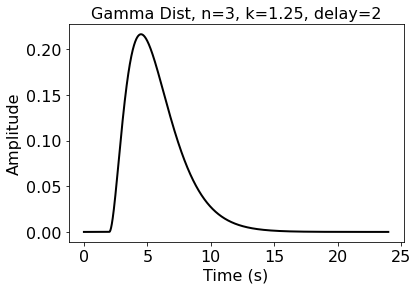

In [3]:
# constants to define gamma dist func

n_cascades = 3 # number of cascades
k = 1.25       # time-constant (seconds)
delay = 2      # onset delay time (seconds)

# time domian to eval gamma distribution function

dt = .01               # time step size (seconds)
maxt = 24              # ending time (seconds)
t = np.arange(0, maxt, dt) # timepoints to eval gamma function

# make the gamma dist function
h = gammaPDF(n_cascades, k, t - delay)

# make a plot - play with n_cascades,k,delay
# to see what happens
plt.plot(t,h, color = 'k')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Gamma Dist, n={n_cascades}, k={k}, delay={delay}', fontsize='medium')
plt.show()

## Blocked design 

One kind of fMRI experimental design is a 'blocked design' where two conditions alternate back and forth.  A typical period for a blocked design is something like 25 seconds.  If we assume that the neuronal response is following the stimulus closely in time (compared to the hemodyanmic response), the neuronal response might look something like this (after subtracting the mean)

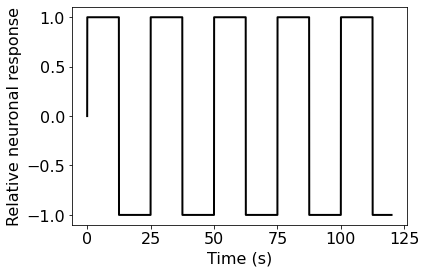

In [4]:
dt = .01               # time step size (seconds)
maxt = 120             # ending time (seconds)
t = np.arange(0, maxt, dt) # timepoints to eval 

# define the experiment params...block duration
period = 25  # seconds

# then our stimulus timeseries 
# in this case, make a square wave to mimic
# stimulus on/off by taking the sign of a sin wave
s = np.sign( np.sin( ( 2*pi*t ) / period ) )

# plot neural signal, under assumption that it closely
# tracks stimulus sequence in time
plt.plot(t, s, color = 'k')
plt.xlabel('Time (s)')
plt.ylabel('Relative neuronal response')
plt.ylim([-1.1,1.1])
plt.show()

## Convolution
If the the time-course of the fMRI signal is a linear function of the neuronal response, then the we can predict the fMRI response to any input by convolving the neuronal response with the hemodynamic impulse response function.  The predicted fMRI response can be calculated using the 'conv' function (this will give us a simulated fMRI timeseries):

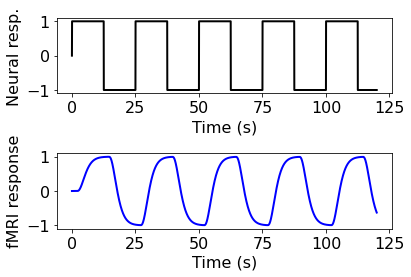

In [5]:
# convolve stimulus/neural signal (s) with our 
# gamma hrf that we made earlier (h) to generate
# the predicted fMRI timeseries
y = np.convolve( s,h ) * dt

# truncate the output to len(t)
y = y[ :len(t) ]

# have a look, and first replot our 
# stimulus/neural signal here for easier comparison
fig, axs = plt.subplots( 2,1 )
axs[0].plot(t,s,'k')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Neural resp.')
axs[0].set_ylim( [-1.1,1.1] )

axs[1].plot(t,y,'b')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('fMRI response')
axs[1].set_ylim( [-1.1,1.1] )

fig.tight_layout()
plt.show()

The output is the expected shape of the fMRI response.  Many software
packages will use a convolution with the stimulus design to produce an
expected response like this as a template to compare to the actual fMRI
data.  This template is correlated with each voxel's time-series to
produce a number between zero and 1, where 1 is a perfect fit.  This
produces a 'parameter map' that can tell us which brain areas are
responding as expected to the experimental paradigm. Note: often this is done in the context of GLM and the resulting value is a 'beta weight', but that is logically similar to the strength of correlation


For a linear system and a blocked-design experiment, the amplitude of the
modulation of the fMRI response is proportional to the amplitude of the
modulation of the neuronal response.  So analyzing the results of a
blocked design experiment is pretty easy - just measure the amplitude of
the modulation fMRI response.


And again - note the temporal shift of the fMRI response relative to the neural response. This is due to the sluggish nature of the hrf that we saw in the first part of the tutorial

## Event-related designs 
But what about more complicated stimuli?  


If we assume that the expected fMRI response is the convolution of the
impulse response with the neuronal response, it's possible work backward
and estimate the hemodynamic response that best predicts a measured fMRI
signal.  This is essentially undoing the convolution process, or
'deconvolution'.


In theory, this should work for any complicated stimulus time-course.  As
we'll see below, one particularly efficient time-course is the event-related 
design in which events may or may not occur randomly at each time-point.


Here's a random event-related sequence, and note that we're increasing the timestep `dt` to 2 seconds to mimic the sampling rate of fMRI (which is referred to as the repetition time, or TR):

In [6]:
dt = 2                 # time step size (seconds)
maxt = 254             # ending time (seconds)
t = np.arange(0, maxt, dt) # timepoints to eval 

# n_tmpnts is the length of the event sequence, or the
# number of timepoints in our stimulus sequence
n_tmpnts = len(t)   

# probability of an event for any given time point
prob = 0.5 

# generate an event sequence - this will generate
# m random numbers over the interval (0,1), then 
# add .5, then take the floor (i.e. < 1 goes to 0, > 1 goes 
# to 1)...quick hack to get a random event sequence with 
# stimulus probability == prob
s = np.floor( random( n_tmpnts ) + prob )

# hold off on plotting the stimulus sequence for a minute
# until we have our simulated fMRI timeseries for comparison

The linear response to this complicated stimulus can be predicted through convolution. We have to re-make our hemodynamic response vector, h, using our more discrete time-steps:

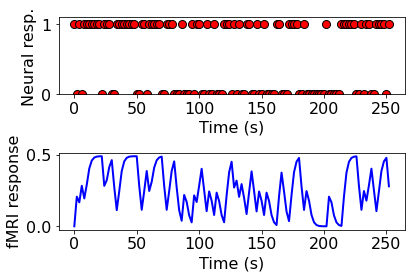

In [7]:
# vector length of hrf in time steps defined for the event-related
# design specified in previous cell
n = 24        

# eval gamma 
h = gammaPDF(n_cascades, k, t[:n])

# convolve our new gamma with stimulus sequence
y = np.convolve( s,h )
y = y[ :n_tmpnts ]

# plot our stim sequence (neural response)
# and our predicted fMRI response to compare
fig, axs = plt.subplots( 2,1 )
axs[0].plot(t,s,'ko', markersize=8, markerfacecolor='r')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Neural resp.')
axs[0].set_ylim( [0,1.1] )

# now the predicted fMRI response
axs[1].plot(t,y,'b')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('fMRI response')

fig.tight_layout()
plt.show()

## Deconvolution

Suppose, now, that we only know the response, y, and our event sequence,
s.  How can we reconstruct the hemodynamic response?  Specifically, if
the hrf has, say, 24 time points, then we need to find the best 24
numbers that will predict our fMRI response. A brute-force method would
be to use a search algorithm to find the best 24 numbers that minimizes
the error between the predicted and the measured fMRI response.
Fortunately, there's an easier and more efficent way using linear
algebra.


The trick is to think of this is a giant linear algebra problem with 24
unknowns and n knowns, where n is the length of the fMRI response.  We
can see that this is a linear algebra problem by noting that convolution
can be conducted through matrix multiplication (indeed, this is how
matlab does it).  This is done by transforming our stimulus sequence, s,
into a 'design matrix' X that, when multipied by the hrf, performs the
convolution.


Remember that convolution is the process of multiplying shifted copies of
the hrf with the input and adding.  Equivalently (since convolution is
commutative) this can be done with shifted copies of the input instead.


The columns of the design matrix, X, are generated by successive shifts of
the stimulus, like this:

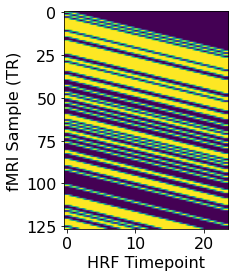

In [8]:
# init design matrix with all zeros
# it will be a [number of timepoints, length of hrf]
# matrix
X = np.zeros( (n_tmpnts,n) )

# assign our stim sequence (s) to a temp
# variable to we can keep s intact as we 
# shift temp...
tmp = s.copy()

for i in np.arange( 0, n ):
    X[:,i] = tmp
    tmp = np.hstack( ( 0, tmp[ :-1 ] ) )


# plot a image - note that each 
# stim is represented by a delta function (a 1)
# at the time of stimulus onset in the first column, 
# and then a delta shifted one timepoint in each 
# subsequent column
plt.imshow(X, aspect = 0.25)
plt.ylabel('fMRI Sample (TR)')
plt.xlabel('HRF Timepoint')
plt.show()

### Convolution of s and h 

We used `np.convolve` above, but we can also achieve the same thing by multiplying the design matrix X and h like this. We should get the same answer if we've set up `X` correctly because X now reflects `n` temporally shifted versions of `s`...

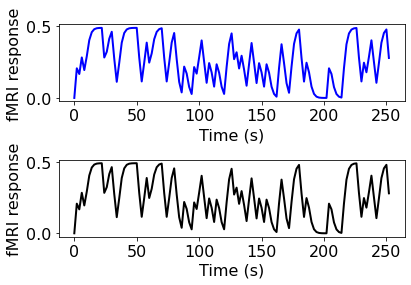

linear algebra works!


In [9]:
# matrix multiply with @...
r = X @ h

# and compare with the results using np.convolve (which we stored in y above)
fig, axs = plt.subplots( 2,1 )
axs[0].plot(t,y,'b')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('fMRI response')

# now the results of multiplying design matrix (X)
# with hrf (h)
axs[1].plot(t,r,'k-')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('fMRI response')

fig.tight_layout()
plt.show()

# should look the same, but we can verify like this
if np.allclose(y,r):
    print('linear algebra works!')
else:
    print('whoops...')


## A little more linear algebra to solve for the observed hrf 

So suppose that the data we just plotted was what we measured in a real experiment. How would we then go back to recover the empirical hrf? This is the process of deconvolution and is usually what we need to do in real life because all we have is the stimulus sequence (s) and the measurements we make (simulated here as r). We don't actually know the evoked fMRI response (the real hrf), and that is the dependent measure that we want to evaluate!
 

Thus far, we've specified `h` in order to generate simulated data...however, as noted above, this is what we want to estimate in a real experiment (i.e. `h` is unknown, which we'll denote with `hest`). 

Here's where the linear algebra comes in. 

if      

$r = X * h$

then if this were normal algebra we could solve for our estimated h (hest) by dividing r by X

$hest = r/X$  

When r and hest are vectors and X is a matrix, this 'division' is done by multiplying by the 'psueudo-inverse'

$PX = inv(X^\intercal*X)*X.^\intercal$, where $^\intercal$ is the transpose operator

Or in Python:

`PX = np.linalg.inv(X.T @ X) @ X.T`

`hest = PX @ r`


Give it a try to see how well `hest` approximates the known `h` that we used to generate the simulated data. It should match perfectly because we didn't add any noise and everything in this simulation is 100% linear. 


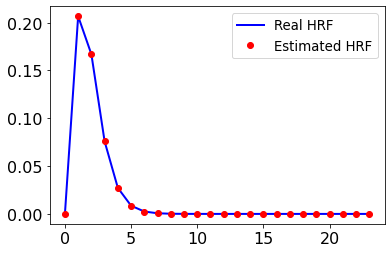

In [10]:
PX = np.linalg.inv(X.T @ X) @ X.T
hest = PX @ r

# plot overlaid...
tg = np.arange(0, n) # timepoints that we used to build our gamma
plt.plot(tg, h, 'b')
plt.plot(tg, hest, 'ro')
plt.legend(['Real HRF', 'Estimated HRF'], fontsize='small')
plt.show()


## What did we just do?  

To recap, we made up a hemodynamic response function (h) convolved it with a random stimulus sequence (s) to get an fMRI response (r).  We then did the whole thing in reverse and reconstructed h (hest) from r and s by deconvolving via the pseudo-inverse.


In this case, the reconstruction `hest` is perfect.  This is because we deconvolved a response to estimate h (hest) that was generated by convolving with h, with no noise to add error to our response.

## Add some noise...
Real data are noisy.  Let's add independently and identically distributed ('iid') noise to the predicted response and see how it affects our ability to reconstruct the hemodynamic response

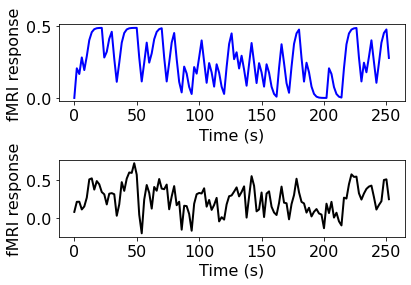

In [11]:
# generate a noisy response (nr)
# by adding zero mean IID noise to our
# original response (r)
noise_sd = 0.1  # sd of the noise
nr = r + randn( n_tmpnts ) * noise_sd

# plot the original, noiseless, response
fig, axs = plt.subplots( 2,1 )
axs[0].plot(t,y,'b')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('fMRI response')

# compare after adding noise...
axs[1].plot(t,nr,'k-')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('fMRI response')
fig.tight_layout()
plt.show()

### Now we'll estimate the hrf (hest) from the noisy data.

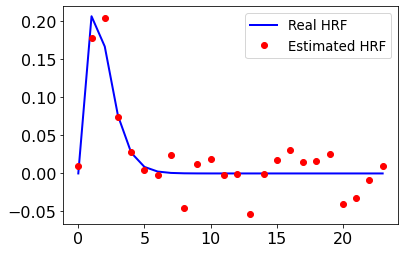

In [12]:
PX = np.linalg.inv(X.T @ X) @ X.T
hest = PX @ nr

# plot overlaid...
tg = np.arange(0, n) # timepoints that we used to build our gamma
plt.plot(tg, h, 'b')
plt.plot(tg, hest, 'ro')
plt.legend(['Real HRF', 'Estimated HRF'], fontsize='small')
plt.show()

You might be surprised how robust our estimate of the hrf is considering how much noise we added to the response.  This is because we have so many knowns (m) to help constrain the number of unknowns (n).  As you can
guess, the longer the event sequence, the better we will be at estimating the true hrf.


Go ahead and play with the magnitude of the noise (noise_sd) and see how it affects the estimate of the hrf.


Bonus material: In Boynton's Matlab tutorial, there are further section for computing the effeciency of a stimulus sequence - that is, you can determine how well a given stimulus sequence should recover hest even before you run an experiment!